At first some python libraries are imported:

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from matplotlib.ticker import FuncFormatter
from shapely.geometry import Polygon, Point

The model data is imported as a dataset:

In [3]:
temp = xr.open_dataset("/students_files/data/slo0043_echam6_code167_mm_1001_8850.ncslo0043_echam6_code167_mm_1001_8850.nc")
large_scale_prec = xr.open_dataset("/students_files/data/slo0043_echam6_code142_mm_1001_8850.ncslo0043_echam6_code142_mm_1001_8850.nc")
convective_prec = xr.open_dataset("/students_files/data/slo0043_echam6_code143_mm_1001_8850.ncslo0043_echam6_code143_mm_1001_8850.nc")
sum_var = large_scale_prec['var142'] + convective_prec['var143']
prec = xr.Dataset({'var260': sum_var})
prec = prec.assign_coords(coords=large_scale_prec.coords)

The longitude and latitude coordinates are adjusted.

In [4]:
# adjust values of lon and lat and show dataset

def adjust_lon_lat(ds, lon_name, lat_name, reverse = False):
    """Adjusts longitude from 0 to 360 to -180 to 180 and reverses latitude."""
    if reverse == True:
        ds = ds.reindex({lat_name:ds[lat_name][::-1]})
    ds['_longitude_adjusted'] = xr.where(
        ds[lon_name] > 180,
        ds[lon_name] - 360,
        ds[lon_name])
    ds = (ds
          .swap_dims({lon_name: '_longitude_adjusted'})
          .sel(**{'_longitude_adjusted': sorted(ds._longitude_adjusted)})
          .drop(lon_name))
    ds = ds.rename({'_longitude_adjusted': lon_name})
    return ds

temp = adjust_lon_lat(temp, lon_name="lon", lat_name="lat", reverse=True)
prec = adjust_lon_lat(prec, lon_name="lon", lat_name="lat", reverse=True)

Creating a Baltic Sea drainage basin boolean mask:

In [5]:
corner_points = [
    (18.0, 49),
    (23.0, 49),
    (28.0, 55.0),
    (32.0, 56.0),
    (35.0, 62.0),
    (30.0, 62.0),
    (29.0, 67.0),
    (19.0, 68.0),
    (12.0, 61.0),
    (12.0, 57.5),
    (8.0, 56.5),
    (10.0, 53.0),
    (13.5, 52.5)
]

polygon = Polygon(corner_points)

lat_mask = (temp['lat'] >= polygon.bounds[1]) & (temp['lat'] <= polygon.bounds[3])
lon_mask = (temp['lon'] >= polygon.bounds[0]) & (temp['lon'] <= polygon.bounds[2])
mask = (lat_mask & lon_mask)

lat_values = temp['lat'].values
lon_values = temp['lon'].values
for i in range(len(lat_values)):
    for j in range(len(lon_values)):
        if not polygon.contains(Point(lon_values[j], lat_values[i])):
            mask[i, j] = False

The baltic region outline for map plots is prepared:

In [6]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def subplot_cartopy_nice_baltic(ax):    
    """
    Adjust cartopy plots for the Baltic Sea
    """
    ax.set_aspect("auto")
    ax.coastlines("10m")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.0, linestyle='-')
    gl.top_labels  = False
    gl.left_labels  = True
    gl.right_labels  = False
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = mticker.FixedLocator(list(np.arange(-90, 60, 10)))
    gl.ylocator = mticker.FixedLocator(list(np.arange(-60, 80, 5)))

    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
    # Change tick label size
    gl.xlabel_style = {'size': 21}
    gl.ylabel_style = {'size': 21}

    ax.spines['geo'].set_linewidth(1)
    ax.spines['geo'].set_edgecolor('black')
    ax.set_aspect('auto')

# Summary

In this notebook i want to summarize my previous work, to make it more understandable and the results more accessible. Therefore I will be investigating the leading questions:

## 1. Are there climate periods where the temperature distinguishs itself from the model mean?

As an answer to this question I focused on four periods with a significant temperature deviation from the total mean. The periods might be interpreted as the Holocene Climate Optimum (HCO) from 2664-1567 BCE, the Medival Climate Anomaly (MCA) from 604-843 CE and two periods connected to the Little Ice Age from 1130-1280 CE (LIA1) and from 1364-1483 CE (LIA2):

In [7]:
# Choose baltic region defined by mask
temp_baltic = temp.where(mask)
# Cropping the dataset, nothing really happpens
temp_baltic = temp_baltic.sel(lat=slice(49, 68), lon=slice(8, 35))
# Averaging over all lat and lon for the time plots
mean_temp_baltic = temp_baltic.mean(dim=['lat', 'lon'])
# Converting from monthly to annual temperature
annual_mean_temp_baltic = mean_temp_baltic['var167'].rolling(time=12).mean().isel(time=slice(11, None, 12))
# Calculating average temperature in total mean
t_mean = mean_temp_baltic.mean(dim=['time'])
t_mean = float(t_mean.var167.values)

# Determining the HCO T-development
temp_hco = annual_mean_temp_baltic.isel(time=slice(-2664 + 6000,-1567 +6000))
temp_hco['time'] = xr.DataArray(range(-2664,-1567), dims='time')
temp_hco -= t_mean

# Determining the MCA T-development
temp_mca = annual_mean_temp_baltic.isel(time=slice(604 +6000,843 +6000))
temp_mca['time'] = xr.DataArray(range(604,843), dims='time')
temp_mca -= t_mean

# Determining the HCO T-development
temp_lia1 = annual_mean_temp_baltic.isel(time=slice(1130 +6000,1280 +6000))
temp_lia1['time'] = xr.DataArray(range(1130,1280), dims='time')
temp_lia1 -= t_mean

# Determining the HCO T-development
temp_lia2 = annual_mean_temp_baltic.isel(time=slice(1364 +6000,1483 +6000))
temp_lia2['time'] = xr.DataArray(range(1364,1483), dims='time')
temp_lia2 -= t_mean

HCO mean T-anomaly: 0.1697K
MCA mean T-anomaly: 0.1623K
LIA1 mean T-anomaly: -0.2165K
LIA2 mean T-anomaly: -0.2780K


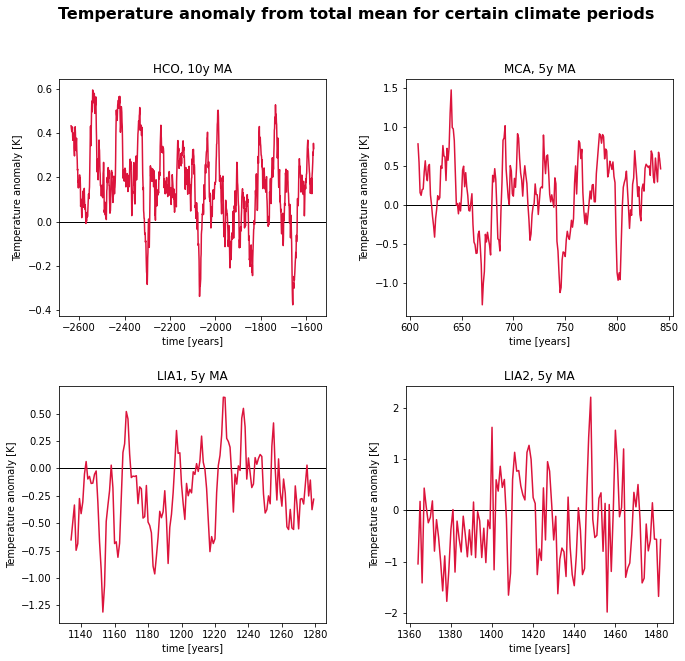

In [8]:
# Creating the four plots
fig, axs = plt.subplots(2, 2, figsize=(11,10), gridspec_kw={"hspace": 0.3, "wspace": 0.3})
fig.suptitle('Temperature anomaly from total mean for certain climate periods', fontsize=16, fontweight='bold');

temp_hco_plot = temp_hco.rolling(time=30).mean()
im1 = axs[0,0].axhline(y=0, color='black', linewidth=1)
axs[0,0].plot(temp_hco_plot['time'], temp_hco_plot, color='crimson')
axs[0,0].set_title('HCO, 10y MA')
axs[0,0].set_xlabel('time [years]')
axs[0,0].set_ylabel('Temperature anomaly [K]')

temp_mca_plot = temp_mca.rolling(time=5).mean()
im2 = axs[0,1].axhline(y=0, color='black', linewidth=1)
axs[0,1].plot(temp_mca_plot['time'], temp_mca_plot, color='crimson')
axs[0,1].set_title('MCA, 5y MA')
axs[0,1].set_xlabel('time [years]')
axs[0,1].set_ylabel('Temperature anomaly [K]')

temp_lia1_plot = temp_lia1.rolling(time=5).mean()
im3 = axs[1,0].axhline(y=0, color='black', linewidth=1)
axs[1,0].plot(temp_lia1_plot['time'], temp_lia1_plot, color='crimson')
axs[1,0].set_title('LIA1, 5y MA')
axs[1,0].set_xlabel('time [years]')
axs[1,0].set_ylabel('Temperature anomaly [K]')

temp_lia2_plot = temp_lia2.rolling(time=1).mean()
im4 = axs[1,1].axhline(y=0, color='black', linewidth=1)
axs[1,1].plot(temp_lia2_plot['time'], temp_lia2_plot, color='crimson')
axs[1,1].set_title('LIA2, 5y MA')
axs[1,1].set_xlabel('time [years]')
axs[1,1].set_ylabel('Temperature anomaly [K]');

print(f"HCO mean T-anomaly: {temp_hco.mean(dim=['time']).values:.4f}K")
print(f"MCA mean T-anomaly: {temp_mca.mean(dim=['time']).values:.4f}K")
print(f"LIA1 mean T-anomaly: {temp_lia1.mean(dim=['time']).values:.4f}K")
print(f"LIA2 mean T-anomaly: {temp_lia2.mean(dim=['time']).values:.4f}K")

## 2. During these periods, in which regions was the climate especially warm or cold?

In [9]:
# Calculating the annual temperature and adapting time scale -6000 to 1850
rolling_temp = temp_baltic['var167'].rolling(time=12).mean().isel(time=slice(11, None, 12))
rolling_temp['time'] = xr.DataArray(range(-6000, rolling_temp.time.size-6000), dims='time')
mean_temp_total = rolling_temp.mean(dim=['time'])

# Calculating HCO mean T heatmap
mean_temp_hco = rolling_temp.isel(time=slice(6000 - 2664, 6000 - 1567)).mean(dim=['time'])
mean_temp_hco = mean_temp_hco - mean_temp_total

# Calculating MCA mean T heatmap
mean_temp_mca = rolling_temp.isel(time=slice(6000 + 604, 6000 + 843)).mean(dim=['time'])
mean_temp_mca = mean_temp_mca - mean_temp_total

# Calculating LIA1 mean T heatmap
mean_temp_lia1 = rolling_temp.isel(time=slice(6000 + 1130, 6000 + 1280)).mean(dim=['time'])
mean_temp_lia1 = mean_temp_lia1 - mean_temp_total

# Calculating LIA2 mean T heatmap
mean_temp_lia2 = rolling_temp.isel(time=slice(6000 + 1364, 6000 + 1483)).mean(dim=['time'])
mean_temp_lia2 = mean_temp_lia2 - mean_temp_total

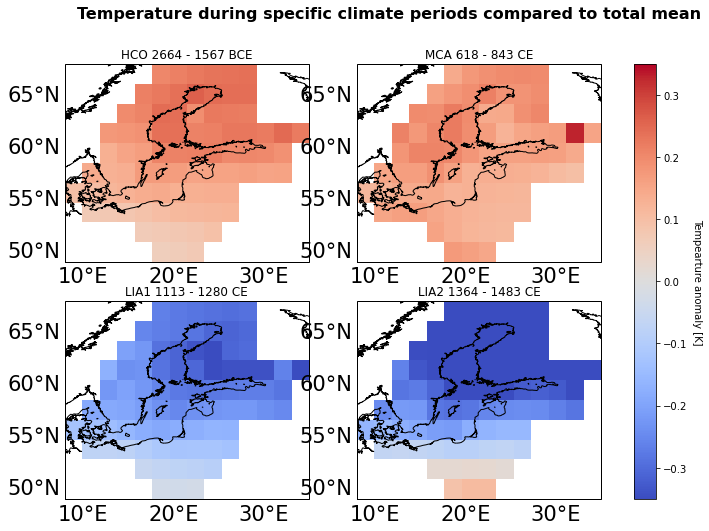

In [10]:
# colorbar range
vmin = -0.35
vmax = 0.35

# Create the four plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections
fig.suptitle('Temperature during specific climate periods compared to total mean', fontsize=16, fontweight='bold')

im1 = axs[0,0].imshow(
    mean_temp_hco,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,0])
axs[0,0].set_title('HCO 2664 - 1567 BCE')

im2 = axs[0,1].imshow(
    mean_temp_mca, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,1])
axs[0,1].set_title('MCA 618 - 843 CE')

im3 = axs[1,0].imshow(
    mean_temp_lia1, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,0])
axs[1,0].set_title('LIA1 1113 - 1280 CE')

im4 = axs[1,1].imshow(
    mean_temp_lia2,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,1])
axs[1,1].set_title('LIA2 1364 - 1483 CE')

cbar = fig.colorbar(im4, ax=axs.ravel().tolist())
cbar.ax.set_ylabel('Tempearture anomaly [K]', rotation=270, labelpad=15)
plt.show()

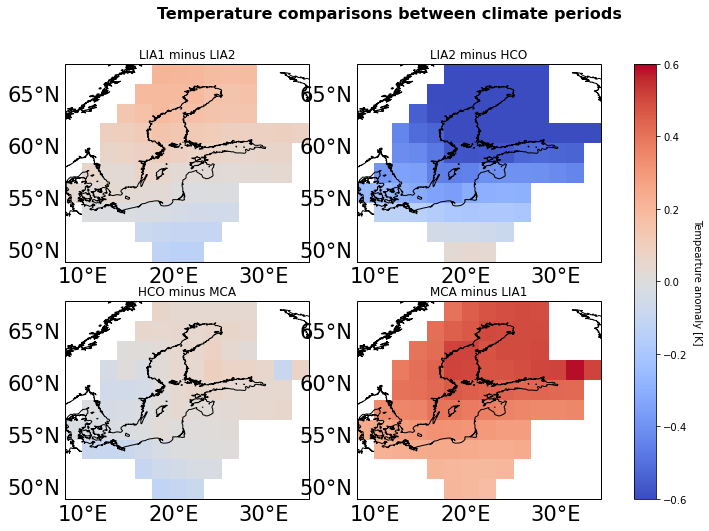

In [11]:
lia1_minus_lia2_temp = mean_temp_lia1 - mean_temp_lia2
lia2_minus_hco_temp = mean_temp_lia2 - mean_temp_hco
hco_minus_mca_temp = mean_temp_hco - mean_temp_mca
mca_minus_lia1_temp = mean_temp_mca - mean_temp_lia1

# colorbar range
vmin = -0.6
vmax = 0.6

# Create the four plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections
fig.suptitle('Temperature comparisons between climate periods', fontsize=16, fontweight='bold')

im1 = axs[0,0].imshow(
    lia1_minus_lia2_temp,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,0])
axs[0,0].spines['geo'].set_linewidth(1)
axs[0,0].set_title('LIA1 minus LIA2')

im2 = axs[0,1].imshow(
    lia2_minus_hco_temp, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,1])
axs[0,1].spines['geo'].set_linewidth(1)
axs[0,1].set_title('LIA2 minus HCO')

im3 = axs[1,0].imshow(
    hco_minus_mca_temp, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,0])
axs[1,0].spines['geo'].set_linewidth(1)
axs[1,0].set_title('HCO minus MCA')

im4 = axs[1,1].imshow(
    mca_minus_lia1_temp,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,1])
axs[1,1].spines['geo'].set_linewidth(1)
axs[1,1].set_title('MCA minus LIA1')

cbar = fig.colorbar(im4, ax=axs.ravel().tolist())
cbar.ax.set_ylabel('Tempearture anomaly [K]', rotation=270, labelpad=15)
plt.show()

In [12]:
# Zusammenfassung

# - hco um 0,17K wärmer und mca um 0,16K wärmer als durchschnitt
# - zwei potentielle lia-zeiträume die je um 0,22K bzw 0,20K kälter waren als durchschnitt
# - in genannten Perioden sind die T-Unterschiede umso stärker je weiter nördlich, bis zu 0,3K wärmer und 0,45K kälter
# - hco im südwesten um 0,1K kälter und im nordosten um 0,1K wärmer als mca (dazwischen kontinuierlicher übergang)
# - beide lia im norden bis zu 0,6K kälter als hco und mca, im süden höchstens 0,2K
# - lia1 im norden 0,1K wärmer und im süden 0,1K kälter als lia2
# - lia2 ganz im süden sogar minimal wärmer als hco dafür im norden deutlich kälter

## 3. During these periods, when and where was the precipitation high or low?

In [13]:
# Choose baltic region defined by mask
prec_baltic = prec.where(mask)
# Cropping the dataset, nothing really happpens
prec_baltic = prec_baltic.sel(lat=slice(49, 68), lon=slice(8, 35))
prec_baltic = prec_baltic * 86400
# Averaging over all lat and lon for the time plots
mean_prec_baltic = prec_baltic.mean(dim=['lat', 'lon'])
# Converting from monthly to annual temperature
annual_mean_prec_baltic = mean_prec_baltic['var260'].rolling(time=12).mean().isel(time=slice(11, None, 12))
# Calculating average temperature in total mean
ns_mean = mean_prec_baltic.mean(dim=['time'])
ns_mean = float(ns_mean.var260.values)

# Determining the HCO T-development
prec_hco = annual_mean_prec_baltic.isel(time=slice(-2664 + 6000,-1567 +6000))
prec_hco['time'] = xr.DataArray(range(-2664,-1567), dims='time')
prec_hco -= ns_mean

# Determining the MCA T-development
prec_mca = annual_mean_prec_baltic.isel(time=slice(604 +6000,843 +6000))
prec_mca['time'] = xr.DataArray(range(604,843), dims='time')
prec_mca -= ns_mean

# Determining the HCO T-development
prec_lia1 = annual_mean_prec_baltic.isel(time=slice(1130 +6000,1280 +6000))
prec_lia1['time'] = xr.DataArray(range(1130,1280), dims='time')
prec_lia1 -= ns_mean

# Determining the HCO T-development
prec_lia2 = annual_mean_prec_baltic.isel(time=slice(1364 +6000,1483 +6000))
prec_lia2['time'] = xr.DataArray(range(1364,1483), dims='time')
prec_lia2 -= ns_mean

Relative HCO mean precipitation anomaly: 0.00362134
Relative MCA mean precipitation anomaly: -0.02093504
Relative LIA1 mean precipitation anomaly: -0.01854552
Relative LIA2 mean precipitation anomaly: -0.00973859


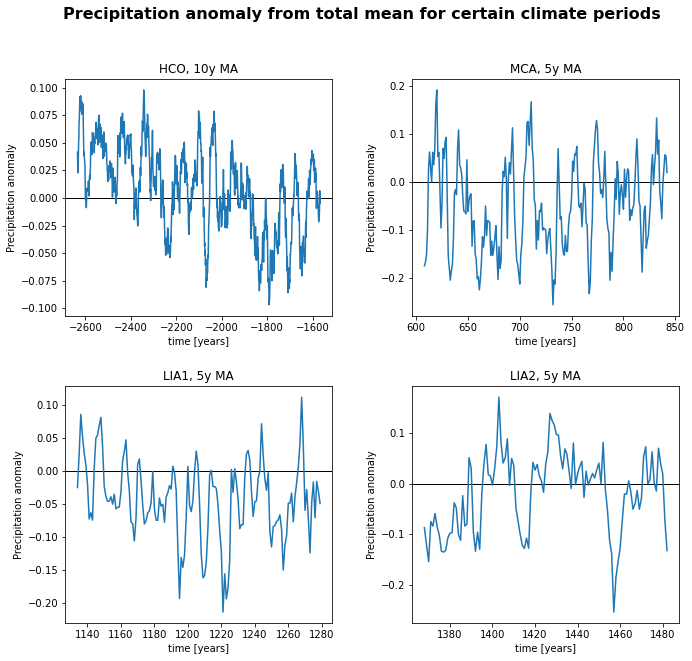

In [84]:
# Creating the four plots
fig, axs = plt.subplots(2, 2, figsize=(11,10), gridspec_kw={"hspace": 0.3, "wspace": 0.3})
fig.suptitle('Precipitation anomaly from total mean for certain climate periods', fontsize=16, fontweight='bold');

prec_hco_plot = prec_hco.rolling(time=30).mean()
im1 = axs[0,0].axhline(y=0, color='black', linewidth=1)
axs[0,0].plot(prec_hco_plot['time'], prec_hco_plot)
axs[0,0].set_title('HCO, 10y MA')
axs[0,0].set_xlabel('time [years]')
axs[0,0].set_ylabel('Precipitation anomaly')

prec_mca_plot = prec_mca.rolling(time=5).mean()
im2 = axs[0,1].axhline(y=0, color='black', linewidth=1)
axs[0,1].plot(prec_mca_plot['time'], prec_mca_plot)
axs[0,1].set_title('MCA, 5y MA')
axs[0,1].set_xlabel('time [years]')
axs[0,1].set_ylabel('Precipitation anomaly')

prec_lia1_plot = prec_lia1.rolling(time=5).mean()
im3 = axs[1,0].axhline(y=0, color='black', linewidth=1)
axs[1,0].plot(prec_lia1_plot['time'], prec_lia1_plot)
axs[1,0].set_title('LIA1, 5y MA')
axs[1,0].set_xlabel('time [years]')
axs[1,0].set_ylabel('Precipitation anomaly')

prec_lia2_plot = prec_lia2.rolling(time=5).mean()
im4 = axs[1,1].axhline(y=0, color='black', linewidth=1)
axs[1,1].plot(prec_lia2_plot['time'], prec_lia2_plot)
axs[1,1].set_title('LIA2, 5y MA')
axs[1,1].set_xlabel('time [years]')
axs[1,1].set_ylabel('Precipitation anomaly');

print(f"Relative HCO mean precipitation anomaly: {prec_hco.mean(dim=['time']).values/ns_mean:.8f}")
print(f"Relative MCA mean precipitation anomaly: {prec_mca.mean(dim=['time']).values/ns_mean:.8f}")
print(f"Relative LIA1 mean precipitation anomaly: {prec_lia1.mean(dim=['time']).values/ns_mean:.8f}")
print(f"Relative LIA2 mean precipitation anomaly: {prec_lia2.mean(dim=['time']).values/ns_mean:.8f}")

HCO mean T-anomaly: 0.1697K
MCA mean T-anomaly: 0.1623K
LIA1 mean T-anomaly: -0.2165K
LIA2 mean T-anomaly: -0.2780K
HCO mean precipitation anomaly: 0.00838310mm/day
MCA mean precipitation anomaly: -0.04846286mm/day
LIA1 mean precipitation anomaly: -0.04293133mm/day
LIA2 mean precipitation anomaly: -0.02254402mm/day


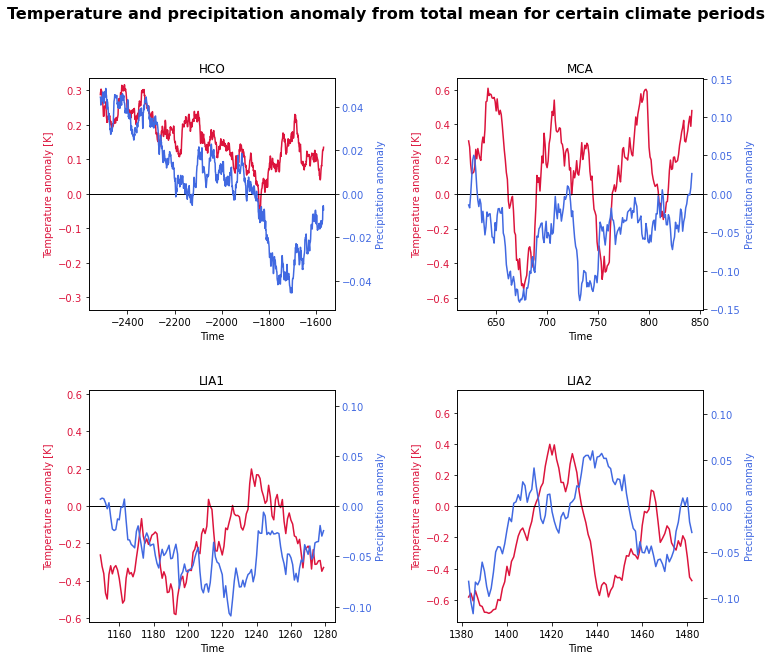

In [15]:
prec_hco_plot = prec_hco.rolling(time=150).mean()
temp_hco_plot = temp_hco.rolling(time=150).mean()
prec_mca_plot = prec_mca.rolling(time=20).mean()
temp_mca_plot = temp_mca.rolling(time=20).mean()
prec_lia1_plot = prec_lia1.rolling(time=20).mean()
temp_lia1_plot = temp_lia1.rolling(time=20).mean()
prec_lia2_plot = prec_lia2.rolling(time=20).mean()
temp_lia2_plot = temp_lia2.rolling(time=20).mean()


fig, axs = plt.subplots(2, 2, figsize=(11,10), gridspec_kw={"hspace": 0.35, "wspace": 0.5})
fig.suptitle('Temperature and precipitation anomaly from total mean for certain climate periods', fontsize=16, fontweight='bold');


for i, ax in enumerate(axs.flat):
    if i == 0:
        temp_hco_plot.plot(ax=ax, color='crimson')
        ax.set_ylabel('Temperature anomaly [K]', color='crimson')
        ax.tick_params(axis='y', labelcolor='crimson')
        ax.set_title('HCO')
        ax.axhline(y=0, color='black', linewidth=1)
        y1_min, y1_max = ax.get_ylim() #these three lines make sure the axes both have zero in the middle
        y1_max = max(abs(y1_min), abs(y1_max))
        ax.set_ylim([-y1_max, y1_max])
        
        ax2 = ax.twinx()
        prec_hco_plot.plot(ax=ax2, color='royalblue')
        ax2.set_ylabel('Precipitation anomaly', color='royalblue')
        ax2.tick_params(axis='y', labelcolor='royalblue')
        y2_min, y2_max = ax2.get_ylim() #these three lines make sure the axes both have zero in the middle
        y2_max = max(abs(y2_min), abs(y2_max))
        ax2.set_ylim([-y2_max, y2_max])
        
    elif i == 1:
        temp_mca_plot.plot(ax=ax, color='crimson')
        ax.set_ylabel('Temperature anomaly [K]', color='crimson')
        ax.tick_params(axis='y', labelcolor='crimson')
        ax.set_title('MCA')
        ax.axhline(y=0, color='black', linewidth=1)
        y1_min, y1_max = ax.get_ylim() #these three lines make sure the axes both have zero in the middle
        y1_max = max(abs(y1_min), abs(y1_max))
        ax.set_ylim([-y1_max, y1_max])
        
        ax2 = ax.twinx()
        prec_mca_plot.plot(ax=ax2, color='royalblue')
        ax2.set_ylabel('Precipitation anomaly', color='royalblue')
        ax2.tick_params(axis='y', labelcolor='royalblue')
        y2_min, y2_max = ax2.get_ylim() #these three lines make sure the axes both have zero in the middle
        y2_max = max(abs(y2_min), abs(y2_max))
        ax2.set_ylim([-y2_max, y2_max])
        
    elif i == 2:
        temp_lia1_plot.plot(ax=ax, color='crimson')
        ax.set_ylabel('Temperature anomaly [K]', color='crimson')
        ax.tick_params(axis='y', labelcolor='crimson')
        ax.set_title('LIA1')
        ax.axhline(y=0, color='black', linewidth=1)
        y1_min, y1_max = ax.get_ylim() #these three lines make sure the axes both have zero in the middle
        y1_max = max(abs(y1_min), abs(y1_max))
        ax.set_ylim([-y1_max, y1_max])
        
        ax2 = ax.twinx()
        prec_lia1_plot.plot(ax=ax2, color='royalblue')
        ax2.set_ylabel('Precipitation anomaly', color='royalblue')
        ax2.tick_params(axis='y', labelcolor='royalblue')
        y2_min, y2_max = ax2.get_ylim() #these three lines make sure the axes both have zero in the middle
        y2_max = max(abs(y2_min), abs(y2_max))
        ax2.set_ylim([-y2_max, y2_max])
        
    elif i == 3:
        temp_lia2_plot.plot(ax=ax, color='crimson')
        ax.set_ylabel('Temperature anomaly [K]', color='crimson')
        ax.tick_params(axis='y', labelcolor='crimson')
        ax.set_title('LIA2')
        ax.axhline(y=0, color='black', linewidth=1)
        y1_min, y1_max = ax.get_ylim() #these three lines make sure the axes both have zero in the middle
        y1_max = max(abs(y1_min), abs(y1_max))
        ax.set_ylim([-y1_max, y1_max])
        
        ax2 = ax.twinx()
        prec_lia2_plot.plot(ax=ax2, color='royalblue')
        ax2.set_ylabel('Precipitation anomaly', color='royalblue')
        ax2.tick_params(axis='y', labelcolor='royalblue')
        y2_min, y2_max = ax2.get_ylim() #these three lines make sure the axes both have zero in the middle
        y2_max = max(abs(y2_min), abs(y2_max))
        ax2.set_ylim([-y2_max, y2_max])

# setting the x-axis label for all subplots
for ax in axs.flat:
    ax.set_xlabel('Time')
    
print(f"HCO mean T-anomaly: {temp_hco.mean(dim=['time']).values:.4f}K")
print(f"MCA mean T-anomaly: {temp_mca.mean(dim=['time']).values:.4f}K")
print(f"LIA1 mean T-anomaly: {temp_lia1.mean(dim=['time']).values:.4f}K")
print(f"LIA2 mean T-anomaly: {temp_lia2.mean(dim=['time']).values:.4f}K")
print(f"HCO mean precipitation anomaly: {prec_hco.mean(dim=['time']).values:.8f}mm/day")
print(f"MCA mean precipitation anomaly: {prec_mca.mean(dim=['time']).values:.8f}mm/day")
print(f"LIA1 mean precipitation anomaly: {prec_lia1.mean(dim=['time']).values:.8f}mm/day")
print(f"LIA2 mean precipitation anomaly: {prec_lia2.mean(dim=['time']).values:.8f}mm/day")

# BA Plot:

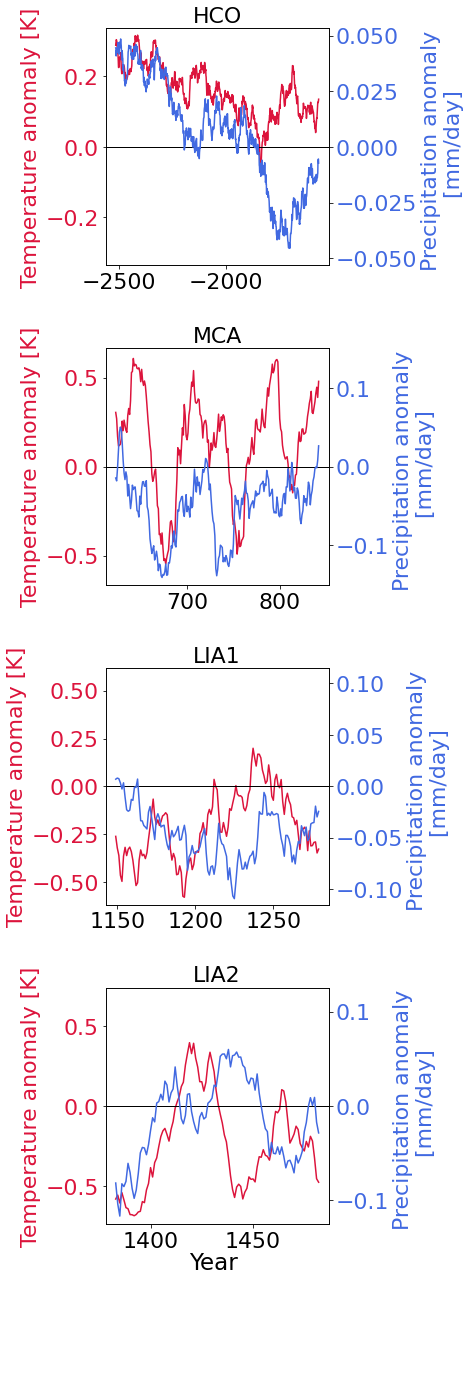

In [76]:
fig, axs = plt.subplots(4, 1, figsize=(4,22), gridspec_kw={"hspace": 0.35, "wspace": 0.3})
#fig.suptitle('Temperature and precipitation anomaly from total mean for certain climate periods', fontsize=16, fontweight='bold');

for i, ax in enumerate(axs.flat):
    if i == 0:
        temp_hco_plot.plot(ax=ax, color='crimson')
        ax.set_ylabel('Temperature anomaly [K]', fontsize='22', color='crimson')
        ax.tick_params(axis='y', labelcolor='crimson', labelsize=22)
        ax.set_title('HCO', fontsize='22')
        ax.axhline(y=0, color='black', linewidth=1)
        y1_min, y1_max = ax.get_ylim() #these three lines make sure the axes both have zero in the middle
        y1_max = max(abs(y1_min), abs(y1_max))
        ax.set_ylim([-y1_max, y1_max])
        
        ax2 = ax.twinx()
        prec_hco_plot.plot(ax=ax2, color='royalblue')
        ax2.set_ylabel('Precipitation anomaly \n [mm/day]', fontsize='22', color='royalblue')
        ax2.tick_params(axis='y', labelcolor='royalblue', labelsize=22)
        y2_min, y2_max = ax2.get_ylim() #these three lines make sure the axes both have zero in the middle
        y2_max = max(abs(y2_min), abs(y2_max))
        ax2.set_ylim([-y2_max, y2_max])
        
    elif i == 1:
        temp_mca_plot.plot(ax=ax, color='crimson')
        ax.set_ylabel('Temperature anomaly [K]', fontsize='22', color='crimson')
        ax.tick_params(axis='y', labelcolor='crimson', labelsize=22)
        ax.set_title('MCA', fontsize='22')
        ax.axhline(y=0, color='black', linewidth=1)
        y1_min, y1_max = ax.get_ylim() #these three lines make sure the axes both have zero in the middle
        y1_max = max(abs(y1_min), abs(y1_max))
        ax.set_ylim([-y1_max, y1_max])
        
        ax2 = ax.twinx()
        prec_mca_plot.plot(ax=ax2, color='royalblue')
        ax2.set_ylabel('Precipitation anomaly \n [mm/day]', fontsize='22', color='royalblue')
        ax2.tick_params(axis='y', labelcolor='royalblue', labelsize=22)
        y2_min, y2_max = ax2.get_ylim() #these three lines make sure the axes both have zero in the middle
        y2_max = max(abs(y2_min), abs(y2_max))
        ax2.set_ylim([-y2_max, y2_max])
        
    elif i == 2:
        temp_lia1_plot.plot(ax=ax, color='crimson')
        ax.set_ylabel('Temperature anomaly [K]', fontsize='22', color='crimson')
        ax.tick_params(axis='y', labelcolor='crimson', labelsize=22)
        ax.set_title('LIA1', fontsize='22')
        ax.axhline(y=0, color='black', linewidth=1)
        y1_min, y1_max = ax.get_ylim() #these three lines make sure the axes both have zero in the middle
        y1_max = max(abs(y1_min), abs(y1_max))
        ax.set_ylim([-y1_max, y1_max])
        
        ax2 = ax.twinx()
        prec_lia1_plot.plot(ax=ax2, color='royalblue')
        ax2.set_ylabel('Precipitation anomaly \n [mm/day]', fontsize='22', color='royalblue')
        ax2.tick_params(axis='y', labelcolor='royalblue', labelsize=22)
        y2_min, y2_max = ax2.get_ylim() #these three lines make sure the axes both have zero in the middle
        y2_max = max(abs(y2_min), abs(y2_max))
        ax2.set_ylim([-y2_max, y2_max])
        
    elif i == 3:
        temp_lia2_plot.plot(ax=ax, color='crimson')
        ax.set_ylabel('Temperature anomaly [K]', fontsize='22', color='crimson')
        ax.tick_params(axis='y', labelcolor='crimson', labelsize=22)
        ax.set_title('LIA2', fontsize='22')
        ax.axhline(y=0, color='black', linewidth=1)
        y1_min, y1_max = ax.get_ylim() #these three lines make sure the axes both have zero in the middle
        y1_max = max(abs(y1_min), abs(y1_max))
        ax.set_ylim([-y1_max, y1_max])
    
        ax2 = ax.twinx()
        prec_lia2_plot.plot(ax=ax2, color='royalblue')
        ax2.set_ylabel('Precipitation anomaly \n [mm/day]', fontsize='22', color='royalblue')
        ax2.tick_params(axis='y', labelcolor='royalblue', labelsize=22)
        y2_min, y2_max = ax2.get_ylim() #these three lines make sure the axes both have zero in the middle
        y2_max = max(abs(y2_min), abs(y2_max))
        ax2.set_ylim([-y2_max, y2_max])
        ax.set_xlabel('Year', fontsize='22')
        
for ax in axs.flat:
    ax.set_xlabel('', fontsize='22')
    ax.tick_params(axis='both', which='major', labelsize=22)
    
for i, ax in enumerate(axs.flat):
    if i == 3:
        ax.set_xlabel('Year \n\n\n\n', fontsize='23', labelpad=0)
    

plt.savefig("/students_files/marti/plots/res_12_periods_anomalies_line", bbox_inches='tight');

In [80]:
# Calculating the annual temperature and adapting time scale -6000 to 1850
rolling_prec = prec_baltic['var260'].rolling(time=12).mean().isel(time=slice(11, None, 12))
rolling_prec['time'] = xr.DataArray(range(-6000, rolling_prec.time.size-6000), dims='time')
mean_prec_total = rolling_prec.mean(dim=['time'])

# Calculating HCO mean T heatmap
mean_prec_hco = rolling_prec.isel(time=slice(6000 - 2664, 6000 - 1567)).mean(dim=['time'])
mean_prec_hco = mean_prec_hco - mean_prec_total

# Calculating MCA mean T heatmap
mean_prec_mca = rolling_prec.isel(time=slice(6000 + 618, 6000 + 843)).mean(dim=['time'])
mean_prec_mca = mean_prec_mca - mean_prec_total

# Calculating LIA1 mean T heatmap
mean_prec_lia1 = rolling_prec.isel(time=slice(6000 + 1130, 6000 + 1280)).mean(dim=['time'])
mean_prec_lia1 = mean_prec_lia1 - mean_prec_total

# Calculating LIA2 mean T heatmap
mean_prec_lia2 = rolling_prec.isel(time=slice(6000 + 1364, 6000 + 1483)).mean(dim=['time'])
mean_prec_lia2 = mean_prec_lia2 - mean_prec_total

<xarray.DataArray ()>
array(2.31491652)


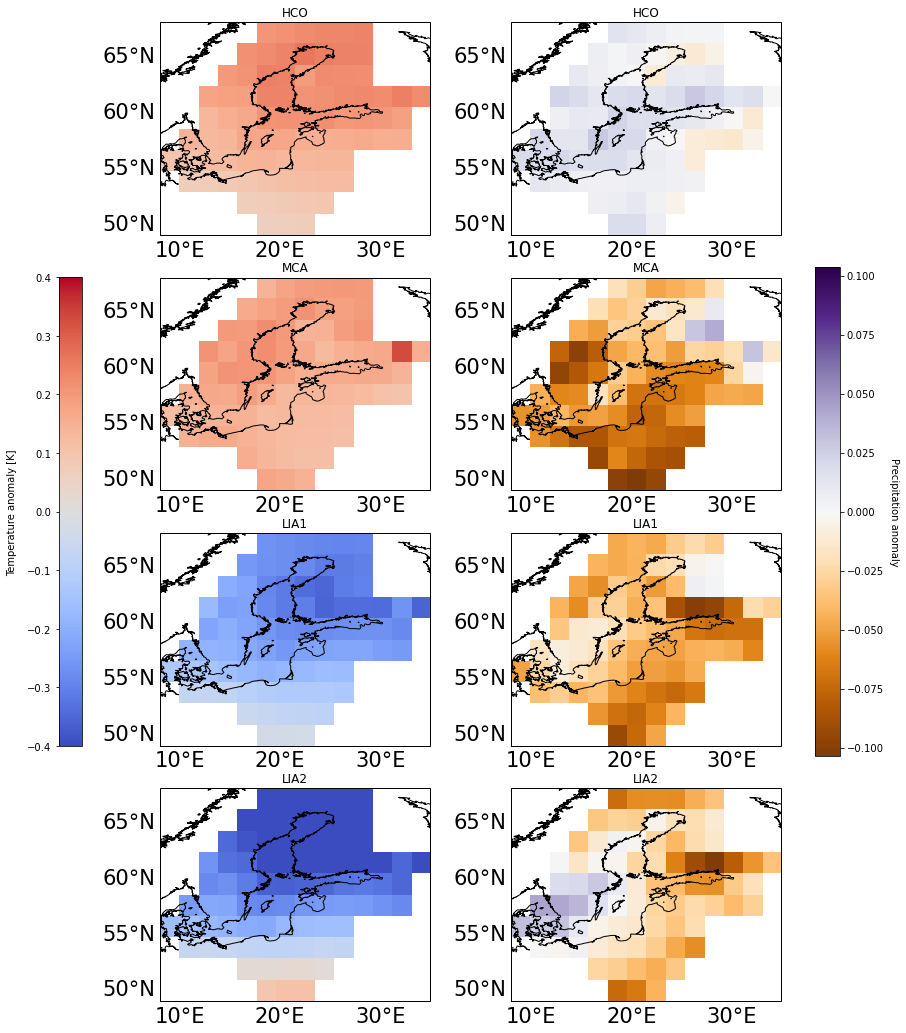

In [17]:
#############################################
                    #TEMP
#############################################

# colorbar range
vmin = -0.4
vmax = 0.4

# Create the four plots
fig, axs = plt.subplots(4, 2, figsize=(14,18), gridspec_kw={"hspace": 0.2, "wspace": 0.3}, subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections
#fig.suptitle('Temperature and precipitation during specific climate periods compared to total mean', fontsize=16, fontweight='bold')

im1 = axs[0,0].imshow(
    mean_temp_hco,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,0])
axs[0,0].set_title('HCO')

im2 = axs[1,0].imshow(
    mean_temp_mca, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,0])
axs[1,0].set_title('MCA')

im3 = axs[2,0].imshow(
    mean_temp_lia1, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[2,0])
axs[2,0].set_title('LIA1')

im4 = axs[3,0].imshow(
    mean_temp_lia2,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[3,0])
axs[3,0].set_title('LIA2')


#############################################
                    #PREC
#############################################


# colorbar range
vmin = -12e-07 * 86400
vmax = 12e-07 * 86400

im5 = axs[0,1].imshow(
    mean_prec_hco,
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,1])
axs[0,1].set_title('HCO')

im6 = axs[1,1].imshow(
    mean_prec_mca, 
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,1])
axs[1,1].set_title('MCA')

im7 = axs[2,1].imshow(
    mean_prec_lia1, 
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[2,1])
axs[2,1].set_title('LIA1')

im8 = axs[3,1].imshow(
    mean_prec_lia2,
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[3,1])
axs[3,1].set_title('LIA2')

cbar1 = fig.colorbar(im4, ax=axs.ravel().tolist(),location='left',fraction=0.03)
cbar1.ax.set_ylabel('Temperature anomaly [K]', rotation=90, labelpad=10);

cbar2 = fig.colorbar(im8, ax=axs.ravel().tolist(),location='right',fraction=0.036)
cbar2.ax.set_ylabel('Precipitation anomaly', rotation=270, labelpad=15);

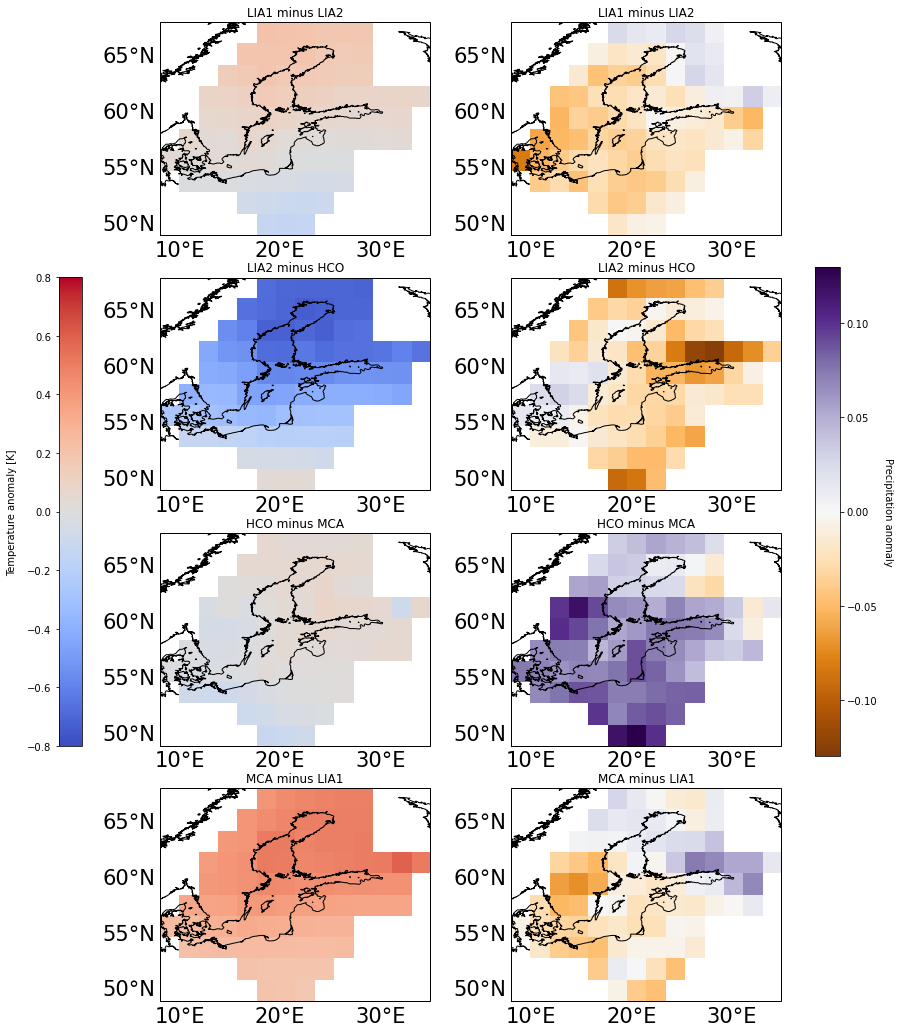

In [23]:
lia1_minus_lia2_prec = mean_prec_lia1 - mean_prec_lia2
lia2_minus_hco_prec = mean_prec_lia2 - mean_prec_hco
hco_minus_mca_prec = mean_prec_hco - mean_prec_mca
mca_minus_lia1_prec = mean_prec_mca - mean_prec_lia1

#############################################
                    #TEMP
#############################################

# colorbar range
vmin = -0.8
vmax = 0.8

# Create the four plots
fig, axs = plt.subplots(4, 2, figsize=(14,18), gridspec_kw={"hspace": 0.2, "wspace": 0.3}, subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections
#fig.suptitle('Temperature and precipitation during specific climate periods compared to total mean', fontsize=16, fontweight='bold')

im1 = axs[0,0].imshow(
    lia1_minus_lia2_temp,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,0])
axs[0,0].set_title('LIA1 minus LIA2')

im2 = axs[1,0].imshow(
    lia2_minus_hco_temp, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,0])
axs[1,0].set_title('LIA2 minus HCO')

im3 = axs[2,0].imshow(
    hco_minus_mca_temp, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[2,0])
axs[2,0].set_title('HCO minus MCA')

im4 = axs[3,0].imshow(
    mca_minus_lia1_temp,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[3,0])
axs[3,0].set_title('MCA minus LIA1')


#############################################
                    #PREC
#############################################


# colorbar range
vmin = -15e-07 *86400
vmax = 15e-07 * 86400

im5 = axs[0,1].imshow(
    lia1_minus_lia2_prec,
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0,1])
axs[0,1].set_title('LIA1 minus LIA2')

im6 = axs[1,1].imshow(
    lia2_minus_hco_prec, 
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1,1])
axs[1,1].set_title('LIA2 minus HCO')

im7 = axs[2,1].imshow(
    hco_minus_mca_prec, 
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[2,1])
axs[2,1].set_title('HCO minus MCA')

im8 = axs[3,1].imshow(
    mca_minus_lia1_prec,
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[3,1])
axs[3,1].set_title('MCA minus LIA1')

cbar1 = fig.colorbar(im4, ax=axs.ravel().tolist(),location='left',fraction=0.03)
cbar1.ax.set_ylabel('Temperature anomaly [K]', rotation=90, labelpad=10);

cbar2 = fig.colorbar(im8, ax=axs.ravel().tolist(),location='right',fraction=0.036)
cbar2.ax.set_ylabel('Precipitation anomaly', rotation=270, labelpad=15);

## BA Plots:

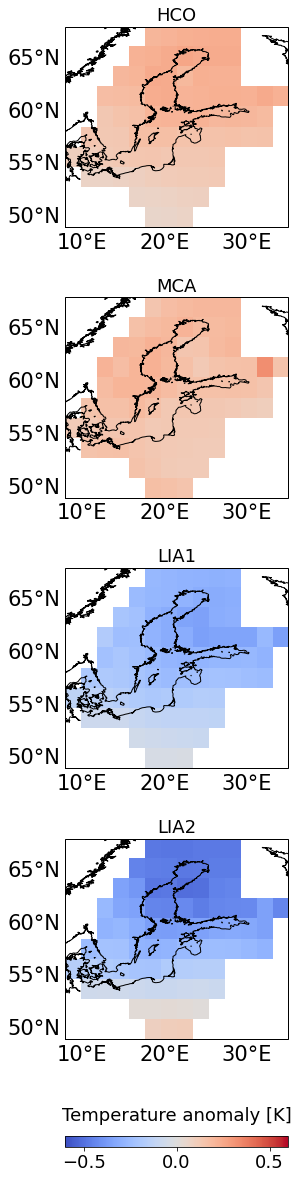

In [78]:
#############################################
                    #TEMP
#############################################

# colorbar range
vmin = -0.6
vmax = 0.6

# Create the four plots
fig, axs = plt.subplots(4, 1, figsize=(4, 24), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections
fig.subplots_adjust(hspace=0.35, wspace=0.3)

im1 = axs[0].imshow(
    mean_temp_hco,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0])
axs[0].set_title('HCO', fontsize = '18')

im2 = axs[1].imshow(
    mean_temp_mca, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1])
axs[1].set_title('MCA', fontsize = '18')

im3 = axs[2].imshow(
    mean_temp_lia1, 
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[2])
axs[2].set_title('LIA1', fontsize = '18')

im4 = axs[3].imshow(
    mean_temp_lia2,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[3])
axs[3].set_title('LIA2', fontsize = '18')

cbar = fig.colorbar(im4, shrink=1, location='bottom', pad=0.074, ax=axs.ravel().tolist())
cbar.ax.tick_params(labelsize=18)
cbar.ax.yaxis.set_label_coords(0.5, 2)
cbar.ax.set_ylabel('Temperature anomaly [K]', fontsize = '18', labelpad=0, rotation=0)
plt.savefig("/students_files/marti/plots/res_10_temp_hcomcalia", bbox_inches='tight')
plt.show();

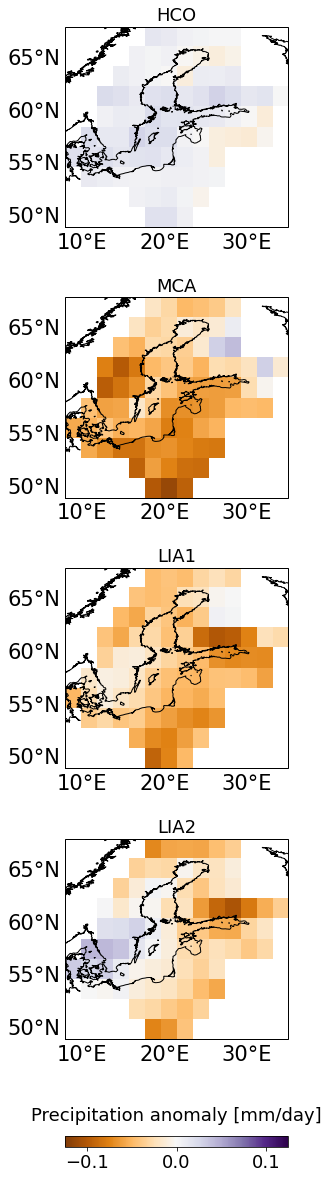

In [61]:
# colorbar range
vmin = -0.125
vmax = 0.125

# Create the four plots
fig, axs = plt.subplots(4, 1, figsize=(4, 24), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections
fig.subplots_adjust(hspace=0.35, wspace=0.3)

im1 = axs[0].imshow(
    mean_prec_hco,
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0])
axs[0].set_title('HCO', fontsize = '18')

im2 = axs[1].imshow(
    mean_prec_mca, 
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1])
axs[1].set_title('MCA', fontsize = '18')

im3 = axs[2].imshow(
    mean_prec_lia1, 
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[2])
axs[2].set_title('LIA1', fontsize = '18')

im4 = axs[3].imshow(
    mean_prec_lia2,
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[3])
axs[3].set_title('LIA2', fontsize = '18')
                    
cbar = fig.colorbar(im4, shrink=1, location='bottom', pad=0.074, ax=axs.ravel().tolist())
cbar.ax.tick_params(labelsize=18)
cbar.ax.yaxis.set_label_coords(0.5, 2)
cbar.ax.set_ylabel('Precipitation anomaly [mm/day]', fontsize = '18', labelpad=0, rotation=0)
plt.savefig("/students_files/marti/plots/res_11_prec_hcomcalia", bbox_inches='tight')
plt.show();

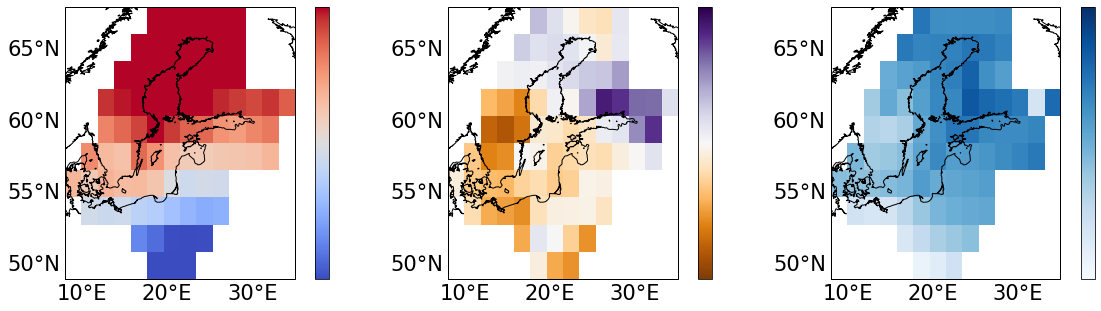

In [19]:
vmin = -0.10
vmax = 0.10

fig, axs = plt.subplots(1, 3, figsize=(19,5), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections
fig.subplots_adjust(hspace=0.4, wspace=0.3)
im1 = axs[0].imshow(
    lia1_minus_lia2_temp,
    cmap='coolwarm',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[0])
cbar1 = fig.colorbar(im1, ax=axs[0], pad=0.07, ticks=[], label='') # remove the ticks and ticklabels from the colorbar
cbar1.ax.yaxis.set_tick_params(size=0)


vmin = -10e-07 * 86400
vmax = 10e-07 * 86400

im2 = axs[1].imshow(
    mca_minus_lia1_prec,
    cmap='PuOr',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[1])
cbar2 = fig.colorbar(im2, ax=axs[1], pad=0.07, ticks=[], label='') # remove the ticks and ticklabels from the colorbar
cbar2.ax.yaxis.set_tick_params(size=0)


vmin = -0.13
vmax = 0.13

im3 = axs[2].imshow(
    hco_minus_mca_temp, 
    cmap='Blues',
    vmin=vmin,
    vmax=vmax,
    origin='lower',
    extent=[8, 35, 49, 68],
    transform=ccrs.PlateCarree()) # The data needs to be transformed for the projection 
subplot_cartopy_nice_baltic(axs[2])
cbar3 = fig.colorbar(im3, ax=axs[2], pad=0.07, ticks=[], label='') # remove the ticks and ticklabels from the colorbar
cbar3.ax.yaxis.set_tick_params(size=0)

## 4. Why is it warm/cold and wet/dry?

To answer this question we will look at shifts of the seasons. 

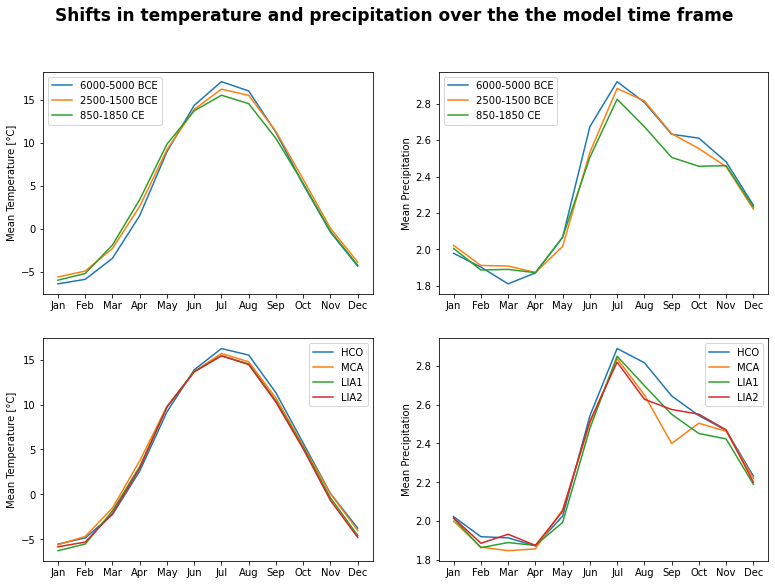

In [20]:
#time slices: 6000-5000BCE, 2500-1500BCE, 850-1850 CE

start_temp = np.zeros(12)
middle_temp = np.zeros(12)
end_temp = np.zeros(12)
start_prec = np.zeros(12)
middle_prec = np.zeros(12)
end_prec = np.zeros(12)
hco_temp =np.zeros(12)
mca_temp = np.zeros(12)
lia1_temp = np.zeros(12)
lia2_temp = np.zeros(12)
hco_prec = np.zeros(12)
mca_prec = np.zeros(12)
lia1_prec = np.zeros(12)
lia2_prec = np.zeros(12)

for i in range (0, 12):
    start_temp[i] = mean_temp_baltic['var167'][i:12000:12].mean() - 273.15
    middle_temp[i] = mean_temp_baltic['var167'][3500*12+i:3500*12+12000:12].mean() - 273.15
    end_temp[i] = mean_temp_baltic['var167'][6850*12+i:6850*12+12000:12].mean() - 273.15
    start_prec[i] = mean_prec_baltic['var260'][i:12000:12].mean()
    middle_prec[i] = mean_prec_baltic['var260'][3500*12+i:3500*12+12000:12].mean()
    end_prec[i] = mean_prec_baltic['var260'][6850*12+i:6850*12+12000:12].mean()
    hco_temp[i] = mean_temp_baltic['var167'][3336*12+i:4433*12:12].mean() - 273.15
    mca_temp[i] = mean_temp_baltic['var167'][6604*12+i:6843*12:12].mean() - 273.15
    lia1_temp[i] = mean_temp_baltic['var167'][7130*12+i:7280*12:12].mean() - 273.15
    lia2_temp[i] = mean_temp_baltic['var167'][7364*12+i:7483*12:12].mean() - 273.15
    hco_prec[i] = mean_prec_baltic['var260'][3336*12+i:4433*12:12].mean()
    mca_prec[i] = mean_prec_baltic['var260'][6604*12+i:6843*12:12].mean()
    lia1_prec[i] = mean_prec_baltic['var260'][7130*12+i:7280*12:12].mean()
    lia2_prec[i] = mean_prec_baltic['var260'][7364*12+i:7483*12:12].mean();
    


months = list(calendar.month_name)[1:]  # get month names as a list
abbrev_months = [month[:3] for month in months]  # get abbreviated month names

fig, axs = plt.subplots(2, 2, figsize=(13,9))
fig.suptitle('Shifts in temperature and precipitation over the the model time frame', fontweight='bold', fontsize=17)

axs[0,0].plot(abbrev_months, start_temp, label='6000-5000 BCE')
axs[0,0].plot(abbrev_months, middle_temp, label='2500-1500 BCE')
axs[0,0].plot(abbrev_months, end_temp, label='850-1850 CE')
axs[0,0].set_ylabel('Mean Temperature [°C]')
axs[0,0].legend()
axs[0,1].plot(abbrev_months, start_prec, label='6000-5000 BCE')
axs[0,1].plot(abbrev_months, middle_prec, label='2500-1500 BCE')
axs[0,1].plot(abbrev_months, end_prec, label='850-1850 CE')
axs[0,1].set_ylabel('Mean Precipitation')
axs[0,1].legend()
axs[1,0].plot(abbrev_months, hco_temp, label='HCO')
axs[1,0].plot(abbrev_months, mca_temp, label='MCA')
axs[1,0].plot(abbrev_months, lia1_temp, label='LIA1')
axs[1,0].plot(abbrev_months, lia2_temp, label='LIA2')
axs[1,0].set_ylabel('Mean Temperature [°C]')
axs[1,0].legend()
axs[1,1].plot(abbrev_months, hco_prec, label='HCO')
axs[1,1].plot(abbrev_months, mca_prec, label='MCA')
axs[1,1].plot(abbrev_months, lia1_prec, label='LIA1')
axs[1,1].plot(abbrev_months, lia2_prec, label='LIA2')
axs[1,1].set_ylabel('Mean Precipitation')
axs[1,1].legend()
plt.show()

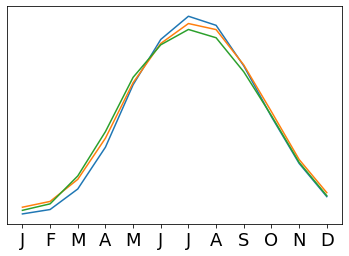

In [21]:
months = list(calendar.month_name)[1:]  # get month names as a list
abbrev_months = [month[:3] for month in months]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(abbrev_months, start_temp, label='6000-5000 BCE')
ax.plot(abbrev_months, middle_temp, label='2500-1500 BCE')
ax.plot(abbrev_months, end_temp, label='850-1850 CE')
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', length=0)
ax.set_xticks(range(len(abbrev_months)))
ax.set_xticklabels([month[0] for month in abbrev_months])
ax.set_yticklabels([])
plt.savefig("/students_files/marti/plots/seasdevplot_illustration");
plt.show()

This doesn't really say a lot so instead of looking at the Baltic Sea drainage basin as one area, let's split this area into three pieces: The Sea covered area, land area north and land area south of 60°N. 

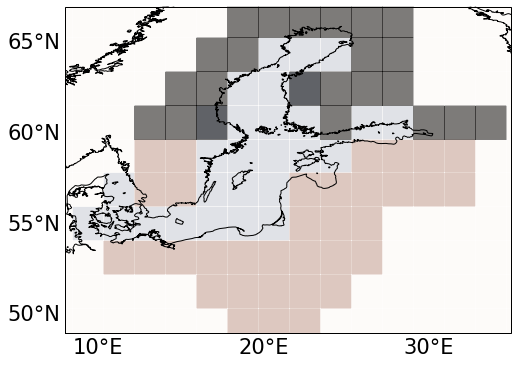

In [22]:
mask_sea = xr.zeros_like(mask, dtype=bool)
mask_sea[77,100] = True;
mask_sea[77,101] = True;
mask_sea[77,102] = True;
mask_sea[77,103] = True;
mask_sea[77,104] = True;
mask_sea[77,105] = True;
mask_sea[77,106] = True;
mask_sea[78,101] = True;
mask_sea[78,104] = True;
mask_sea[78,105] = True;
mask_sea[78,106] = True;
mask_sea[79,104] = True;
mask_sea[79,105] = True;
mask_sea[79,106] = True;
mask_sea[79,107] = True;
mask_sea[79,108] = True;
mask_sea[80,104] = True;
mask_sea[80,105] = True;
mask_sea[80,106] = True;
mask_sea[80,107] = True;
mask_sea[80,109] = True;
mask_sea[80,110] = True;
mask_sea[81,105] = True;
mask_sea[81,106] = True;
mask_sea[81,107] = True;
mask_sea[82,106] = True;
mask_sea[82,107] = True;
mask_sea[82,108] = True;


mask_land_s = xr.zeros_like(mask, dtype=bool)
mask_land_s[74,105] = True;
mask_land_s[74,106] = True;
mask_land_s[74,107] = True;
mask_land_s[75,104] = True;
mask_land_s[75,105] = True;
mask_land_s[75,106] = True;
mask_land_s[75,107] = True;
mask_land_s[75,108] = True;
mask_land_s[76,101] = True;
mask_land_s[76,102] = True;
mask_land_s[76,103] = True;
mask_land_s[76,104] = True;
mask_land_s[76,105] = True;
mask_land_s[76,106] = True;
mask_land_s[76,107] = True;
mask_land_s[76,108] = True;
mask_land_s[76,109] = True;
mask_land_s[77,107] = True;
mask_land_s[77,108] = True;
mask_land_s[77,109] = True;
mask_land_s[78,102] = True;
mask_land_s[78,103] = True;
mask_land_s[78,107] = True;
mask_land_s[78,108] = True;
mask_land_s[78,109] = True;
mask_land_s[78,110] = True;
mask_land_s[78,111] = True;
mask_land_s[78,112] = True;
mask_land_s[79,102] = True;
mask_land_s[79,103] = True;
mask_land_s[79,109] = True;
mask_land_s[79,110] = True;
mask_land_s[79,111] = True;
mask_land_s[79,112] = True;


mask_land_n = xr.zeros_like(mask, dtype=bool)
mask_land_n[80,102] = True;
mask_land_n[80,103] = True;
mask_land_n[80,104] = True;
mask_land_n[80,108] = True;
mask_land_n[80,111] = True;
mask_land_n[80,112] = True;
mask_land_n[80,113] = True;
mask_land_n[81,103] = True;
mask_land_n[81,104] = True;
mask_land_n[81,107] = True;
mask_land_n[81,108] = True;
mask_land_n[81,109] = True;
mask_land_n[81,110] = True;
mask_land_n[82,104] = True;
mask_land_n[82,105] = True;
mask_land_n[82,109] = True;
mask_land_n[82,110] = True;
mask_land_n[83,105] = True;
mask_land_n[83,106] = True;
mask_land_n[83,107] = True;
mask_land_n[83,108] = True;
mask_land_n[83,109] = True;
mask_land_n[83,110] = True;


x, y = np.meshgrid(temp['lon'], temp['lat'])

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(projection=ccrs.PlateCarree())) # define projections
im = plt.pcolormesh(x, y, mask_sea, cmap='Blues', shading='auto', transform=ccrs.PlateCarree(), alpha=0.5) # The data needs to be transformed for the projection
im = plt.pcolormesh(x, y, mask_land_s, cmap='Oranges', shading='auto', transform=ccrs.PlateCarree(), alpha=0.5) # The data needs to be transformed for the projection
im = plt.pcolormesh(x, y, mask_land_n, cmap='gray_r', shading='auto', transform=ccrs.PlateCarree(), alpha=0.5) # The data needs to be transformed for the projection
subplot_cartopy_nice_baltic(ax)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(8, 35)
plt.ylim(49, 67,4)

plt.savefig("/students_files/marti/plots/three_masks");

In [24]:
mean_temp_sea = temp.where(mask_sea).mean(dim=['lat', 'lon'])
mean_temp_land_n = temp.where(mask_land_n).mean(dim=['lat', 'lon'])
mean_temp_land_s = temp.where(mask_land_s).mean(dim=['lat', 'lon'])

In [28]:
mean_prec_sea = prec.where(mask_sea).mean(dim=['lat', 'lon']) * 86400
mean_prec_land_n = prec.where(mask_land_n).mean(dim=['lat', 'lon']) * 86400
mean_prec_land_s = prec.where(mask_land_s).mean(dim=['lat', 'lon']) * 86400

[0.58238095 0.59738976 0.5317849  0.54077972 0.51445196 0.52400993
 0.56739679 0.72968037 0.93094448 0.83406888 0.72035713 0.65332006]
[0.57514338 0.59780964 0.51913189 0.56550312 0.64492636 0.74264763
 0.74635055 0.8091054  0.88380213 0.81083202 0.70689565 0.61137386]
[0.56453948 0.59392713 0.55609899 0.59852389 0.62017059 0.691709
 0.61976479 0.65002528 0.76799286 0.75003752 0.68204576 0.62639388]


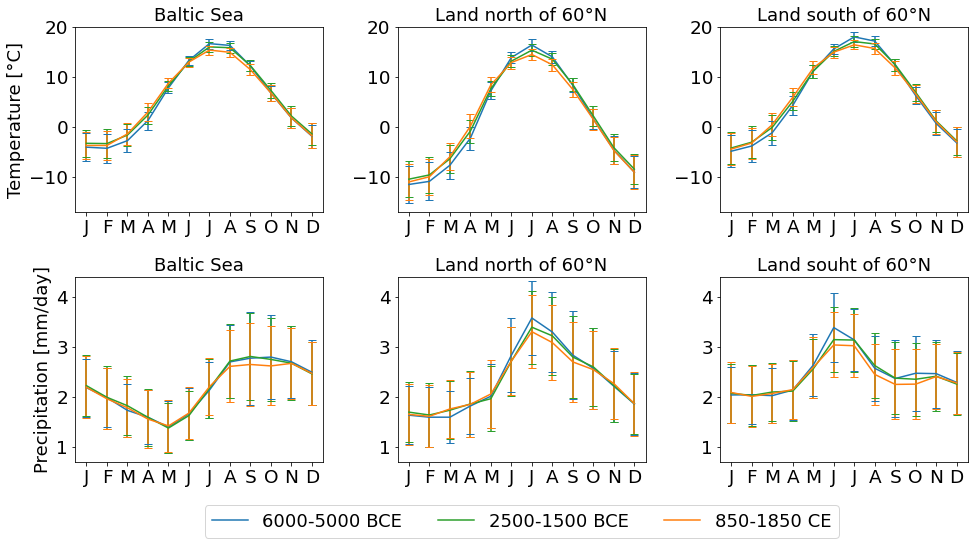

In [148]:
#time slices: 6000-5000BCE, 2500-1500BCE, 850-1850 CE
start_temp = np.zeros(12)
middle_temp = np.zeros(12)
end_temp = np.zeros(12)
start_prec = np.zeros(12)
middle_prec = np.zeros(12)
end_prec = np.zeros(12)
std_start_temp = np.zeros(12)
std_middle_temp = np.zeros(12)
std_end_temp = np.zeros(12)
std_start_prec = np.zeros(12)
std_middle_prec = np.zeros(12)
std_end_prec = np.zeros(12)

months = list(calendar.month_name)[1:]  # get month names as a list
abbrev_months = [month[:3] for month in months]  # get abbreviated month names


fig, axs = plt.subplots(2, 3, figsize=(16,8))
fig.subplots_adjust(hspace=0.35, wspace=0.3)
#fig.suptitle('Seasonal shifts in temperature and precipitation', fontweight='bold', fontsize=17)

for i in range (0, 12):
    start_temp[i] = mean_temp_sea['var167'][i:12000:12].mean() - 273.15
    std_start_temp[i] = mean_temp_sea['var167'][i:12000:12].std()
    middle_temp[i] = mean_temp_sea['var167'][3500*12+i:3500*12+12000:12].mean() - 273.15
    std_middle_temp[i] = mean_temp_sea['var167'][3500*12+i:3500*12+12000:12].std()
    end_temp[i] = mean_temp_sea['var167'][6850*12+i:6850*12+12000:12].mean() - 273.15
    std_end_temp[i] = mean_temp_sea['var167'][6850*12+i:6850*12+12000:12].std()
    start_prec[i] = mean_prec_sea['var260'][i:12000:12].mean()
    std_start_prec[i] = mean_prec_sea['var260'][i:12000:12].std()
    middle_prec[i] = mean_prec_sea['var260'][3500*12+i:3500*12+12000:12].mean()
    std_middle_prec[i] = mean_prec_sea['var260'][3500*12+i:3500*12+12000:12].std()
    end_prec[i] = mean_prec_sea['var260'][6850*12+i:6850*12+12000:12].mean()
    std_end_prec[i] = mean_prec_sea['var260'][6850*12+i:6850*12+12000:12].std();
print(std_start_prec)
axs[0,0].plot(abbrev_months, start_temp, label='6000-5000 BCE', color='tab:blue')
axs[0,0].errorbar(abbrev_months, start_temp, yerr=std_start_temp, fmt='none', capsize=4, color='tab:blue')
axs[0,0].plot(abbrev_months, middle_temp, label='2500-1500 BCE', color='tab:green')
axs[0,0].errorbar(abbrev_months, middle_temp, yerr=std_middle_temp, fmt='none', capsize=4, color='tab:green')
axs[0,0].plot(abbrev_months, end_temp, label='850-1850 CE', color='tab:orange')
axs[0,0].errorbar(abbrev_months, end_temp, yerr=std_end_temp, fmt='none', capsize=4, color='tab:orange')
axs[0,0].set_ylabel('Temperature [°C]', fontsize = '18')
axs[0,0].set_title('Baltic Sea', fontsize = '18')
axs[0,0].tick_params(axis='both', which='major', labelsize=18.5)
axs[0,0].set_xticks(range(len(abbrev_months)))
axs[0,0].set_xticklabels([month[0] for month in abbrev_months])
axs[0,0].set_ylim([-17, 20])
axs[1,0].plot(abbrev_months, start_prec, label='6000-5000 BCE', color='tab:blue')
axs[1,0].errorbar(abbrev_months, start_prec, yerr=std_start_prec, fmt='none', capsize=4, color='tab:blue')
axs[1,0].plot(abbrev_months, middle_prec, label='2500-1500 BCE', color='tab:green')
axs[1,0].errorbar(abbrev_months, middle_prec, yerr=std_middle_prec, fmt='none', capsize=4, color='tab:green')
axs[1,0].plot(abbrev_months, end_prec, label='850-1850 CE', color='tab:orange')
axs[1,0].errorbar(abbrev_months, end_prec, yerr=std_end_prec, fmt='none', capsize=4, color='tab:orange')
axs[1,0].set_ylabel('Precipitation [mm/day]', fontsize = '18')
axs[1,0].set_title('Baltic Sea', fontsize = '18')
axs[1,0].tick_params(axis='both', which='major', labelsize=18.5)
axs[1,0].set_xticks(range(len(abbrev_months)))
axs[1,0].set_xticklabels([month[0] for month in abbrev_months])
axs[1,0].set_ylim([0.7, 4.4])

for i in range (0, 12):
    start_temp[i] = mean_temp_land_n['var167'][i:12000:12].mean() - 273.15
    std_start_temp[i] = mean_temp_land_n['var167'][i:12000:12].std()
    middle_temp[i] = mean_temp_land_n['var167'][3500*12+i:3500*12+12000:12].mean() - 273.15
    std_middle_temp[i] = mean_temp_land_n['var167'][3500*12+i:3500*12+12000:12].std()
    end_temp[i] = mean_temp_land_n['var167'][6850*12+i:6850*12+12000:12].mean() - 273.15
    std_end_temp[i] = mean_temp_land_n['var167'][6850*12+i:6850*12+12000:12].std()
    start_prec[i] = mean_prec_land_n['var260'][i:12000:12].mean()
    std_start_prec[i] = mean_prec_land_n['var260'][i:12000:12].std()
    middle_prec[i] = mean_prec_land_n['var260'][3500*12+i:3500*12+12000:12].mean()
    std_middle_prec[i] = mean_prec_land_n['var260'][3500*12+i:3500*12+12000:12].std()
    end_prec[i] = mean_prec_land_n['var260'][6850*12+i:6850*12+12000:12].mean()
    std_end_prec[i] = mean_prec_land_n['var260'][6850*12+i:6850*12+12000:12].std();
print(std_start_prec)
axs[0,1].plot(abbrev_months, start_temp, label='6000-5000 BCE', color='tab:blue')
axs[0,1].errorbar(abbrev_months, start_temp, yerr=std_start_temp, fmt='none', capsize=4, color='tab:blue')
axs[0,1].plot(abbrev_months, middle_temp, label='2500-1500 BCE', color='tab:green')
axs[0,1].errorbar(abbrev_months, middle_temp, yerr=std_middle_temp, fmt='none', capsize=4, color='tab:green')
axs[0,1].plot(abbrev_months, end_temp, label='850-1850 CE', color='tab:orange')
axs[0,1].errorbar(abbrev_months, end_temp, yerr=std_end_temp, fmt='none', capsize=4, color='tab:orange')
#axs[0,1].set_ylabel('Temperature [°C]', fontsize = '18')
axs[0,1].set_title('Land north of 60°N', fontsize = '18')
axs[0,1].tick_params(axis='both', which='major', labelsize=18.5)
axs[0,1].set_xticks(range(len(abbrev_months)))
axs[0,1].set_xticklabels([month[0] for month in abbrev_months])
axs[0,1].set_ylim([-17, 20])
axs[1,1].plot(abbrev_months, start_prec, label='6000-5000 BCE', color='tab:blue')
axs[1,1].errorbar(abbrev_months, start_prec, yerr=std_start_prec, fmt='none', capsize=4, color='tab:blue')
axs[1,1].plot(abbrev_months, middle_prec, label='2500-1500 BCE', color='tab:green')
axs[1,1].errorbar(abbrev_months, middle_prec, yerr=std_middle_prec, fmt='none', capsize=4, color='tab:green')
axs[1,1].plot(abbrev_months, end_prec, label='850-1850 CE', color='tab:orange')
axs[1,1].errorbar(abbrev_months, end_prec, yerr=std_end_prec, fmt='none', capsize=4, color='tab:orange')
#axs[1,1].set_ylabel('Precipitation [mm/day]', fontsize = '18')
axs[1,1].set_title('Land north of 60°N', fontsize = '18')
axs[1,1].tick_params(axis='both', which='major', labelsize=18.5)
axs[1,1].set_xticks(range(len(abbrev_months)))
axs[1,1].set_xticklabels([month[0] for month in abbrev_months])
axs[1,1].set_ylim([0.7, 4.4])
axs[1,1].legend(loc='upper center', ncol=3, fontsize=18, bbox_to_anchor=(0.5, -0.188))


for i in range (0, 12):
    start_temp[i] = mean_temp_land_s['var167'][i:12000:12].mean() - 273.15
    std_start_temp[i] = mean_temp_land_s['var167'][i:12000:12].std()
    middle_temp[i] = mean_temp_land_s['var167'][3500*12+i:3500*12+12000:12].mean() - 273.15
    std_middle_temp[i] = mean_temp_land_s['var167'][3500*12+i:3500*12+12000:12].std()
    end_temp[i] = mean_temp_land_s['var167'][6850*12+i:6850*12+12000:12].mean() - 273.15
    std_end_temp[i] = mean_temp_land_s['var167'][6850*12+i:6850*12+12000:12].std()
    start_prec[i] = mean_prec_land_s['var260'][i:12000:12].mean()
    std_start_prec[i] = mean_prec_land_s['var260'][i:12000:12].std()
    middle_prec[i] = mean_prec_land_s['var260'][3500*12+i:3500*12+12000:12].mean()
    std_middle_prec[i] = mean_prec_land_s['var260'][3500*12+i:3500*12+12000:12].std()
    end_prec[i] = mean_prec_land_s['var260'][6850*12+i:6850*12+12000:12].mean()
    std_end_prec[i] = mean_prec_land_s['var260'][6850*12+i:6850*12+12000:12].std();
print(std_start_prec)
axs[0,2].plot(abbrev_months, start_temp, label='6000-5000 BCE', color='tab:blue')
axs[0,2].errorbar(abbrev_months, start_temp, yerr=std_start_temp, fmt='none', capsize=4, color='tab:blue')
axs[0,2].plot(abbrev_months, middle_temp, label='2500-1500 BCE', color='tab:green')
axs[0,2].errorbar(abbrev_months, middle_temp, yerr=std_middle_temp, fmt='none', capsize=4, color='tab:green')
axs[0,2].plot(abbrev_months, end_temp, label='850-1850 CE', color='tab:orange')
axs[0,2].errorbar(abbrev_months, end_temp, yerr=std_end_temp, fmt='none', capsize=4, color='tab:orange')
#axs[0,2].set_ylabel('Temperature [°C]', fontsize = '18')
axs[0,2].set_title('Land south of 60°N', fontsize = '18')
axs[0,2].tick_params(axis='both', which='major', labelsize=18.5)
axs[0,2].set_xticks(range(len(abbrev_months)))
axs[0,2].set_xticklabels([month[0] for month in abbrev_months])
axs[0,2].set_ylim([-17, 20])
axs[1,2].plot(abbrev_months, start_prec, label='6000-5000 BCE', color='tab:blue')
axs[1,2].errorbar(abbrev_months, start_prec, yerr=std_start_prec, fmt='none', capsize=4, color='tab:blue')
axs[1,2].plot(abbrev_months, middle_prec, label='2500-1500 BCE', color='tab:green')
axs[1,2].errorbar(abbrev_months, middle_prec, yerr=std_middle_prec, fmt='none', capsize=4, color='tab:green')
axs[1,2].plot(abbrev_months, end_prec, label='850-1850 CE', color='tab:orange')
axs[1,2].errorbar(abbrev_months, end_prec, yerr=std_end_prec, fmt='none', capsize=4, color='tab:orange')
#axs[1,2].set_ylabel('Precipitation [mm/day]', fontsize = '18')
axs[1,2].set_title('Land souht of 60°N', fontsize = '18')
axs[1,2].tick_params(axis='both', which='major', labelsize=18.5)
axs[1,2].set_xticks(range(len(abbrev_months)))
axs[1,2].set_xticklabels([month[0] for month in abbrev_months])
axs[1,2].set_ylim([0.7, 4.4])

plt.savefig("/students_files/marti/plots/res_07_seascycle_3map", bbox_inches='tight');

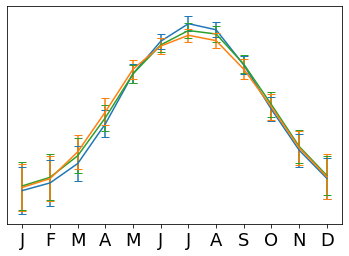

In [163]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(abbrev_months, start_temp, label='6000-5000 BCE', color='tab:blue')
ax.errorbar(abbrev_months, start_temp, yerr=std_start_temp, fmt='none', capsize=4, color='tab:blue')
ax.plot(abbrev_months, middle_temp, label='2500-1500 BCE', color='tab:green')
ax.errorbar(abbrev_months, middle_temp, yerr=std_middle_temp, fmt='none', capsize=4, color='tab:green')
ax.plot(abbrev_months, end_temp, label='850-1850 CE', color='tab:orange')
ax.errorbar(abbrev_months, end_temp, yerr=std_end_temp, fmt='none', capsize=4, color='tab:orange')
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', length=0)
ax.set_xticks(range(len(abbrev_months)))
ax.set_xticklabels([month[0] for month in abbrev_months])
ax.set_yticklabels([])
plt.savefig("/students_files/marti/plots/seasdevplot_illustration");
plt.show()

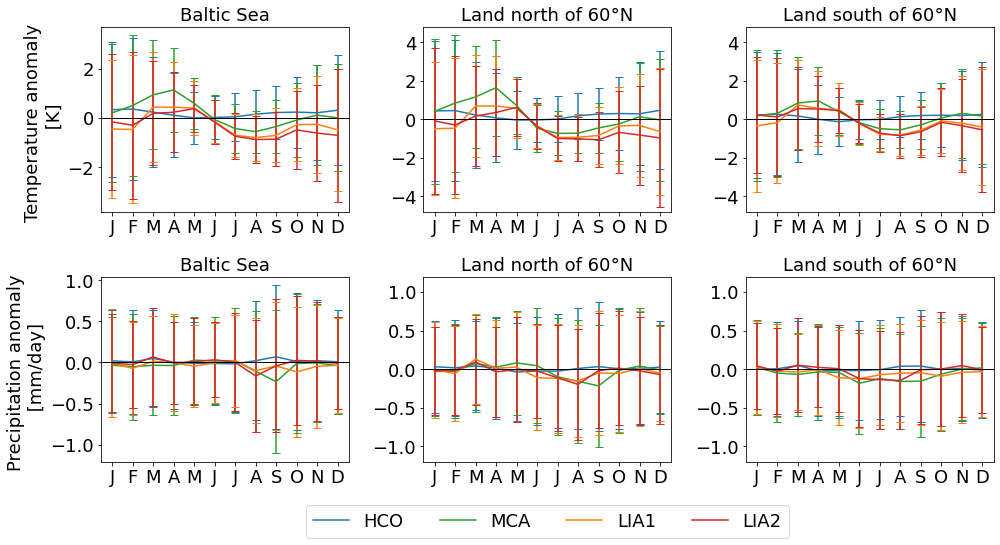

In [169]:
#time slices: 6000-5000BCE, 2500-1500BCE, 850-1850 CE

hco_temp =np.zeros(12)
mca_temp = np.zeros(12)
lia1_temp = np.zeros(12)
lia2_temp = np.zeros(12)
total_temp = np.zeros(12)
hco_prec = np.zeros(12)
mca_prec = np.zeros(12)
lia1_prec = np.zeros(12)
lia2_prec = np.zeros(12)
total_prec = np.zeros(12)
std_hco_temp =np.zeros(12)
std_mca_temp = np.zeros(12)
std_lia1_temp = np.zeros(12)
std_lia2_temp = np.zeros(12)
std_total_temp = np.zeros(12)
std_hco_prec = np.zeros(12)
std_mca_prec = np.zeros(12)
std_lia1_prec = np.zeros(12)
std_lia2_prec = np.zeros(12)
std_total_prec = np.zeros(12)

months = list(calendar.month_name)[1:]  # get month names as a list
abbrev_months = [month[:3] for month in months]  # get abbreviated month names

fig, axs = plt.subplots(2, 3, figsize=(16,8))
fig.subplots_adjust(hspace=0.35, wspace=0.3)
#fig.suptitle('Seasonal shifts in temperature and precipitation between climate periods', fontweight='bold', fontsize=17)

for i in range (0, 12):
    hco_temp[i] = mean_temp_sea['var167'][3336*12+i:4433*12:12].mean() - 273.15
    std_hco_temp[i] = mean_temp_sea['var167'][3336*12+i:4433*12:12].std()
    mca_temp[i] = mean_temp_sea['var167'][6604*12+i:6843*12:12].mean() - 273.15
    std_mca_temp[i] = mean_temp_sea['var167'][6604*12+i:6843*12:12].std()
    lia1_temp[i] = mean_temp_sea['var167'][7130*12+i:7280*12:12].mean() - 273.15
    std_lia1_temp[i] = mean_temp_sea['var167'][7130*12+i:7280*12:12].std()
    lia2_temp[i] = mean_temp_sea['var167'][7364*12+i:7483*12:12].mean() - 273.15
    std_lia2_temp[i] = mean_temp_sea['var167'][7364*12+i:7483*12:12].std()
    total_temp[i] = mean_temp_sea['var167'][i::12].mean() - 273.15
    std_total_temp[i] = mean_temp_sea['var167'][i::12].std()
    hco_prec[i] = mean_prec_sea['var260'][3336*12+i:4433*12:12].mean()
    std_hco_prec[i] = mean_prec_sea['var260'][3336*12+i:4433*12:12].std()
    mca_prec[i] = mean_prec_sea['var260'][6604*12+i:6843*12:12].mean()
    std_mca_prec[i] = mean_prec_sea['var260'][6604*12+i:6843*12:12].std()
    lia1_prec[i] = mean_prec_sea['var260'][7130*12+i:7280*12:12].mean()
    std_lia1_prec[i] = mean_prec_sea['var260'][7130*12+i:7280*12:12].std()
    lia2_prec[i] = mean_prec_sea['var260'][7364*12+i:7483*12:12].mean()
    std_lia2_prec[i] = mean_prec_sea['var260'][7364*12+i:7483*12:12].std()
    total_prec[i] = mean_prec_sea['var260'][i::12].mean()
    std_total_prec[i] = mean_prec_sea['var260'][i::12].std();
axs[0,0].plot(abbrev_months, hco_temp-total_temp, label='HCO', color='tab:blue')
axs[0,0].errorbar(abbrev_months, hco_temp-total_temp, yerr=std_hco_temp, fmt='none', capsize=4, color='tab:blue')
axs[0,0].plot(abbrev_months, mca_temp-total_temp, label='MCA', color='tab:green')
axs[0,0].errorbar(abbrev_months, mca_temp-total_temp, yerr=std_mca_temp, fmt='none', capsize=4, color='tab:green')
axs[0,0].plot(abbrev_months, lia1_temp-total_temp, label='LIA1', color='tab:orange')
axs[0,0].errorbar(abbrev_months, lia1_temp-total_temp, yerr=std_lia1_temp, fmt='none', capsize=4, color='tab:orange')
axs[0,0].plot(abbrev_months, lia2_temp-total_temp, label='LIA2', color='tab:red')
axs[0,0].errorbar(abbrev_months, lia2_temp-total_temp, yerr=std_lia2_temp, fmt='none', capsize=4, color='tab:red')
axs[0,0].axhline(y=0, color='black', linewidth=1)
axs[0,0].set_ylabel('Temperature anomaly \n [K]', fontsize = '18')
axs[0,0].set_title('Baltic Sea', fontsize = '18')
axs[0,0].tick_params(axis='both', which='major', labelsize=18)
axs[0,0].set_xticks(range(len(abbrev_months)))
axs[0,0].set_xticklabels([month[0] for month in abbrev_months])
#axs[0,0].set_ylim([-4.8, 4.8])
axs[1,0].plot(abbrev_months, hco_prec-total_prec, label='HCO', color='tab:blue')
axs[1,0].errorbar(abbrev_months, hco_prec-total_prec, yerr=std_hco_prec, fmt='none', capsize=4, color='tab:blue')
axs[1,0].plot(abbrev_months, mca_prec-total_prec, label='MCA', color='tab:green')
axs[1,0].errorbar(abbrev_months, mca_prec-total_prec, yerr=std_mca_prec, fmt='none', capsize=4, color='tab:green')
axs[1,0].plot(abbrev_months, lia1_prec-total_prec, label='LIA1', color='tab:orange')
axs[1,0].errorbar(abbrev_months, lia1_prec-total_prec, yerr=std_lia1_prec, fmt='none', capsize=4, color='tab:orange')
axs[1,0].plot(abbrev_months, lia2_prec-total_prec, label='LIA2', color='tab:red')
axs[1,0].errorbar(abbrev_months, lia2_prec-total_prec, yerr=std_lia2_prec, fmt='none', capsize=4, color='tab:red')
axs[1,0].axhline(y=0, color='black', linewidth=1)
axs[1,0].set_ylabel('Precipitation anomaly \n [mm/day]', fontsize = '18')
axs[1,0].set_title('Baltic Sea', fontsize = '18')
axs[1,0].tick_params(axis='both', which='major', labelsize=18)
axs[1,0].set_xticks(range(len(abbrev_months)))
axs[1,0].set_xticklabels([month[0] for month in abbrev_months])
#axs[1,0].set_ylim([-1.2,1.2])

for i in range (0, 12):
    hco_temp[i] = mean_temp_land_n['var167'][3336*12+i:4433*12:12].mean() - 273.15
    std_hco_temp[i] = mean_temp_land_n['var167'][3336*12+i:4433*12:12].std()
    mca_temp[i] = mean_temp_land_n['var167'][6604*12+i:6843*12:12].mean() - 273.15
    std_mca_temp[i] = mean_temp_land_n['var167'][6604*12+i:6843*12:12].std()
    lia1_temp[i] = mean_temp_land_n['var167'][7130*12+i:7280*12:12].mean() - 273.15
    std_lia1_temp[i] = mean_temp_land_n['var167'][7130*12+i:7280*12:12].std()
    lia2_temp[i] = mean_temp_land_n['var167'][7364*12+i:7483*12:12].mean() - 273.15
    std_lia2_temp[i] = mean_temp_land_n['var167'][7364*12+i:7483*12:12].std()
    total_temp[i] = mean_temp_land_n['var167'][i::12].mean() - 273.15
    std_total_temp[i] = mean_temp_land_n['var167'][i::12].std()
    hco_prec[i] = mean_prec_land_n['var260'][3336*12+i:4433*12:12].mean()
    std_hco_prec[i] = mean_prec_land_n['var260'][3336*12+i:4433*12:12].std()
    mca_prec[i] = mean_prec_land_n['var260'][6604*12+i:6843*12:12].mean()
    std_mca_prec[i] = mean_prec_land_n['var260'][6604*12+i:6843*12:12].std()
    lia1_prec[i] = mean_prec_land_n['var260'][7130*12+i:7280*12:12].mean()
    std_lia1_prec[i] = mean_prec_land_n['var260'][7130*12+i:7280*12:12].std()
    lia2_prec[i] = mean_prec_land_n['var260'][7364*12+i:7483*12:12].mean()
    std_lia2_prec[i] = mean_prec_land_n['var260'][7364*12+i:7483*12:12].std()
    total_prec[i] = mean_prec_land_n['var260'][i::12].mean()
    std_total_prec[i] = mean_prec_land_n['var260'][i::12].std();
axs[0,1].plot(abbrev_months, hco_temp-total_temp, label='HCO', color='tab:blue')
axs[0,1].errorbar(abbrev_months, hco_temp-total_temp, yerr=std_hco_temp, fmt='none', capsize=4, color='tab:blue')
axs[0,1].plot(abbrev_months, mca_temp-total_temp, label='MCA', color='tab:green')
axs[0,1].errorbar(abbrev_months, mca_temp-total_temp, yerr=std_mca_temp, fmt='none', capsize=4, color='tab:green')
axs[0,1].plot(abbrev_months, lia1_temp-total_temp, label='LIA1', color='tab:orange')
axs[0,1].errorbar(abbrev_months, lia1_temp-total_temp, yerr=std_lia1_temp, fmt='none', capsize=4, color='tab:orange')
axs[0,1].plot(abbrev_months, lia2_temp-total_temp, label='LIA2', color='tab:red')
axs[0,1].errorbar(abbrev_months, lia2_temp-total_temp, yerr=std_lia2_temp, fmt='none', capsize=4, color='tab:red')
axs[0,1].axhline(y=0, color='black', linewidth=1)
#axs[0,1].set_ylabel('Temperature anomaly \n [K]', fontsize = '18')
axs[0,1].set_title('Land north of 60°N', fontsize = '18')
axs[0,1].tick_params(axis='both', which='major', labelsize=18)
axs[0,1].set_xticks(range(len(abbrev_months)))
axs[0,1].set_xticklabels([month[0] for month in abbrev_months])
axs[0,1].set_ylim([-4.8, 4.8])
axs[1,1].plot(abbrev_months, hco_prec-total_prec, label='HCO', color='tab:blue')
axs[1,1].errorbar(abbrev_months, hco_prec-total_prec, yerr=std_hco_prec, fmt='none', capsize=4, color='tab:blue')
axs[1,1].plot(abbrev_months, mca_prec-total_prec, label='MCA', color='tab:green')
axs[1,1].errorbar(abbrev_months, mca_prec-total_prec, yerr=std_mca_prec, fmt='none', capsize=4, color='tab:green')
axs[1,1].plot(abbrev_months, lia1_prec-total_prec, label='LIA1', color='tab:orange')
axs[1,1].errorbar(abbrev_months, lia1_prec-total_prec, yerr=std_lia1_prec, fmt='none', capsize=4, color='tab:orange')
axs[1,1].plot(abbrev_months, lia2_prec-total_prec, label='LIA2', color='tab:red')
axs[1,1].errorbar(abbrev_months, lia2_prec-total_prec, yerr=std_lia2_prec, fmt='none', capsize=4, color='tab:red')
axs[1,1].axhline(y=0, color='black', linewidth=1)
#axs[1,1].set_ylabel('Precipitation anomaly \n [mm/day]', fontsize = '18')
axs[1,1].set_title('Land north of 60°N', fontsize = '18')
axs[1,1].tick_params(axis='both', which='major', labelsize=18)
axs[1,1].set_xticks(range(len(abbrev_months)))
axs[1,1].set_xticklabels([month[0] for month in abbrev_months])
axs[1,1].set_ylim([-1.2,1.2])
axs[1,1].legend(loc='upper center', ncol=6, fontsize=18, bbox_to_anchor=(0.5, -0.188))

for i in range (0, 12):
    hco_temp[i] = mean_temp_land_s['var167'][3336*12+i:4433*12:12].mean() - 273.15
    std_hco_temp[i] = mean_temp_land_s['var167'][3336*12+i:4433*12:12].std()
    mca_temp[i] = mean_temp_land_s['var167'][6604*12+i:6843*12:12].mean() - 273.15
    std_mca_temp[i] = mean_temp_land_s['var167'][6604*12+i:6843*12:12].std()
    lia1_temp[i] = mean_temp_land_s['var167'][7130*12+i:7280*12:12].mean() - 273.15
    std_lia1_temp[i] = mean_temp_land_s['var167'][7130*12+i:7280*12:12].std()
    lia2_temp[i] = mean_temp_land_s['var167'][7364*12+i:7483*12:12].mean() - 273.15
    std_lia2_temp[i] = mean_temp_land_s['var167'][7364*12+i:7483*12:12].std()
    total_temp[i] = mean_temp_land_s['var167'][i::12].mean() - 273.15
    std_total_temp[i] = mean_temp_land_s['var167'][i::12].std()
    hco_prec[i] = mean_prec_land_s['var260'][3336*12+i:4433*12:12].mean()
    std_hco_prec[i] = mean_prec_land_s['var260'][3336*12+i:4433*12:12].std()
    mca_prec[i] = mean_prec_land_s['var260'][6604*12+i:6843*12:12].mean()
    std_mca_prec[i] = mean_prec_land_s['var260'][6604*12+i:6843*12:12].std()
    lia1_prec[i] = mean_prec_land_s['var260'][7130*12+i:7280*12:12].mean()
    std_lia1_prec[i] = mean_prec_land_s['var260'][7130*12+i:7280*12:12].std()
    lia2_prec[i] = mean_prec_land_s['var260'][7364*12+i:7483*12:12].mean()
    std_lia2_prec[i] = mean_prec_land_s['var260'][7364*12+i:7483*12:12].std()
    total_prec[i] = mean_prec_land_s['var260'][i::12].mean()
    std_total_prec[i] = mean_prec_land_s['var260'][i::12].std();
axs[0,2].plot(abbrev_months, hco_temp-total_temp, label='HCO', color='tab:blue')
axs[0,2].errorbar(abbrev_months, hco_temp-total_temp, yerr=std_hco_temp, fmt='none', capsize=4, color='tab:blue')
axs[0,2].plot(abbrev_months, mca_temp-total_temp, label='MCA', color='tab:green')
axs[0,2].errorbar(abbrev_months, mca_temp-total_temp, yerr=std_mca_temp, fmt='none', capsize=4, color='tab:green')
axs[0,2].plot(abbrev_months, lia1_temp-total_temp, label='LIA1', color='tab:orange')
axs[0,2].errorbar(abbrev_months, lia1_temp-total_temp, yerr=std_lia1_temp, fmt='none', capsize=4, color='tab:orange')
axs[0,2].plot(abbrev_months, lia2_temp-total_temp, label='LIA2', color='tab:red')
axs[0,2].errorbar(abbrev_months, lia2_temp-total_temp, yerr=std_lia2_temp, fmt='none', capsize=4, color='tab:red')
axs[0,2].axhline(y=0, color='black', linewidth=1)
#axs[0,2].set_ylabel('Temperature anomaly \n [K]', fontsize = '18')
axs[0,2].set_title('Land south of 60°N', fontsize = '18')
axs[0,2].tick_params(axis='both', which='major', labelsize=18)
axs[0,2].set_xticks(range(len(abbrev_months)))
axs[0,2].set_xticklabels([month[0] for month in abbrev_months])
axs[0,2].set_ylim([-4.8, 4.8])
axs[1,2].plot(abbrev_months, hco_prec-total_prec, label='HCO', color='tab:blue')
axs[1,2].errorbar(abbrev_months, hco_prec-total_prec, yerr=std_hco_prec, fmt='none', capsize=4, color='tab:blue')
axs[1,2].plot(abbrev_months, mca_prec-total_prec, label='MCA', color='tab:green')
axs[1,2].errorbar(abbrev_months, mca_prec-total_prec, yerr=std_mca_prec, fmt='none', capsize=4, color='tab:green')
axs[1,2].plot(abbrev_months, lia1_prec-total_prec, label='LIA1', color='tab:orange')
axs[1,2].errorbar(abbrev_months, lia1_prec-total_prec, yerr=std_lia1_prec, fmt='none', capsize=4, color='tab:orange')
axs[1,2].plot(abbrev_months, lia2_prec-total_prec, label='LIA2', color='tab:red')
axs[1,2].errorbar(abbrev_months, lia2_prec-total_prec, yerr=std_lia2_prec, fmt='none', capsize=4, color='tab:red')
axs[1,2].axhline(y=0, color='black', linewidth=1)
#axs[1,2].set_ylabel('Precipitation anomaly \n [mm/day]', fontsize = '18')
axs[1,2].set_title('Land south of 60°N', fontsize = '18')
axs[1,2].tick_params(axis='both', which='major', labelsize=18)
axs[1,2].set_xticks(range(len(abbrev_months)))
axs[1,2].set_xticklabels([month[0] for month in abbrev_months])
axs[1,2].set_ylim([-1.2,1.2]);

plt.savefig("/students_files/marti/plots/res_13_seascycle_period_anonamlies_3map", bbox_inches='tight');